In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, permutation_test_score

## Importing and formating data

In [2]:
# import data from file
file_path = 'winequality/winequality-white.csv'
data = np.genfromtxt(file_path, delimiter=';', skip_header=1)
print(data)

[[ 7.    0.27  0.36 ...  0.45  8.8   6.  ]
 [ 6.3   0.3   0.34 ...  0.49  9.5   6.  ]
 [ 8.1   0.28  0.4  ...  0.44 10.1   6.  ]
 ...
 [ 6.5   0.24  0.19 ...  0.46  9.4   6.  ]
 [ 5.5   0.29  0.3  ...  0.38 12.8   7.  ]
 [ 6.    0.21  0.38 ...  0.32 11.8   6.  ]]


In [3]:
# normalize parameters to [0,1]
for i in range(len(data[0,:-1])):
    mi = min(data[:,i])
    ma = max(data[:,i])
    data[:,i] -= mi
    data[:,i] /= (ma - mi)
# Shuffle the rows just in case we want to split data in parts and they're sorted
np.random.shuffle(data)
print(data)

[[0.15384615 0.18137255 0.1686747  ... 0.18604651 0.38709677 6.        ]
 [0.30769231 0.35294118 0.14457831 ... 0.3255814  0.24193548 5.        ]
 [0.32692308 0.5245098  0.06024096 ... 0.30232558 0.27419355 4.        ]
 ...
 [0.18269231 0.60294118 0.03614458 ... 0.25581395 0.35483871 5.        ]
 [0.22115385 0.29411765 0.28313253 ... 0.3255814  0.25806452 5.        ]
 [0.42307692 0.14705882 0.22289157 ... 0.1627907  0.32258065 5.        ]]


In [4]:
X = data[:, :-1]
y = data[:, -1].astype(int)

## Finding optimal kernel hyperparameters

In [5]:
C_opt = 2.4
gamma_opt = 72

In [6]:
'''
#parameters = {'C':[0.01, 0.1, 1, 10, 100], 'gamma':[0.01, 0.1, 1, 10, 100]}
#parameters = {'C':[1, 1.2, 1.3, 1.4, 1.6], 'gamma':[8, 9, 10, 11, 13]}
parameters = {'C':[2.1, 2.3, 2.4, 2.5, 2.7], 'gamma':[65, 68, 70, 72, 75]}

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=123)
scores = np.zeros((len(parameters['C']), len(parameters['gamma'])))

for iC, C in enumerate(parameters['C']):
    for ig, gamma in enumerate(parameters['gamma']):
        model = svm.SVC(kernel='rbf', gamma=gamma, C=C).fit(X_train, y_train)
        pred = model.predict(X_test)
        for i in range(len(y_test)):
            scores[iC, ig] += (pred[i] - y_test[i]) ** 2

opt_indices = np.unravel_index(np.argmin(scores), scores.shape)
C_opt = parameters['C'][opt_indices[0]]           # white: 2.4  red: 1.3
gamma_opt = parameters['gamma'][opt_indices[1]]   # white: 72   red: 10

print(scores)
print('best score: ', scores[opt_indices])
print("C_opt     = ", C_opt)
print("gamma_opt = ", gamma_opt)
'''

[[514. 516. 522. 523. 518.]
 [514. 524. 523. 522. 523.]
 [520. 524. 527. 528. 526.]
 [523. 528. 529. 524. 529.]
 [530. 528. 529. 525. 529.]]
best score:  514.0
C_opt     =  2.1
gamma_opt =  65


## Training the model

In [9]:
samplesize = len(y)
divisions = 5
divsize = samplesize//divisions
models = []
preds = []
accuracies = np.zeros(divisions)

for i in range(divisions):
    X_cvtrn = np.concatenate((X[:i*divsize, :], X[(i+1)*divsize:, :]))
    X_cvtst = X[i*divsize:(i+1)*divsize, :]
    y_cvtrn = np.concatenate((y[:i*divsize], y[(i+1)*divsize:]))
    y_cvtst = y[i*divsize:(i+1)*divsize]
    models.append(svm.SVC(kernel='rbf', gamma=gamma_opt, C=C_opt).fit(X_cvtrn, y_cvtrn))
    preds.append(models[i].predict(X_cvtst))
    accuracies[i] = accuracy_score(y_cvtst, preds[i])
    print(accuracies[i]*100)

accuracy = np.average(accuracies)
accuracy_stdev = np.std(accuracies)
print('\nAccuracy: ', "%.2f" % accuracy, '   stdev: ', "%.2f" % accuracy_stdev)


66.18998978549541
64.4535240040858
64.55566905005107
64.96424923391216
63.73850868232891

Accuracy:  0.65    stdev:  0.01


### Confusion matrix

In [13]:
conf_mtrx = np.zeros((10, 10))
for j in range(divisions):
    y_t = y[j*divsize:(j+1)*divsize]
    for i in range(len(y_t)):
        conf_mtrx[preds[j][i]-1, y_t[i]-1] += 1

acc_with_tolerance = (np.sum(np.diag(conf_mtrx, k=1)) + np.sum(np.diag(conf_mtrx)) + np.sum(np.diag(conf_mtrx, k=-1))) / np.sum(conf_mtrx)
print('\nAccuracy (accepting off-by-one estimates): ', "%.3f" % acc_with_tolerance)


Accuracy (accepting off-by-one estimates):  0.951


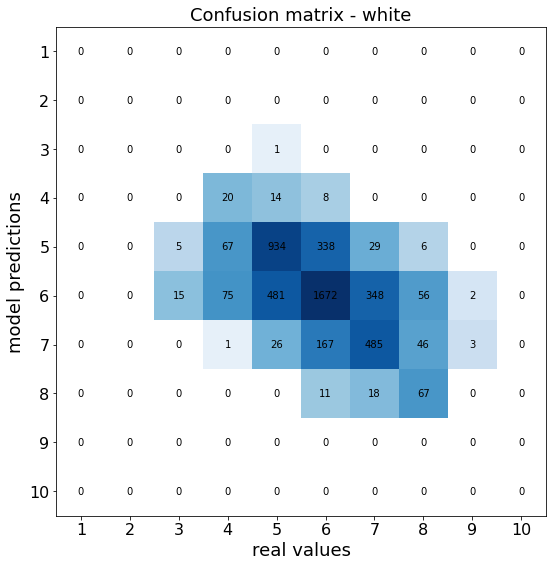

In [10]:
plt.figure(figsize=(9, 9))
cmap = LinearSegmentedColormap.from_list('custom_cmap', list(zip([0, 1/conf_mtrx.max(), 1], [(1, 1, 1), (0.78, 0.86, 0.93), (0.03, 0.19, 0.42)])))
plt.imshow(conf_mtrx, interpolation='nearest', cmap='Blues', norm=mcolors.LogNorm(vmin=0.5, vmax=conf_mtrx.max()))

for i in range(conf_mtrx.shape[0]):
    for j in range(conf_mtrx.shape[1]):
        plt.text(j, i, "{:.0f}".format(conf_mtrx[i, j]), ha='center', va='center', color='black')

#plt.colorbar()
plt.xticks(np.arange(0, conf_mtrx.shape[1], 1), np.arange(1, conf_mtrx.shape[1]+1, 1), fontsize=16)
plt.yticks(np.arange(0, conf_mtrx.shape[0], 1), np.arange(1, conf_mtrx.shape[0]+1, 1), fontsize=16)
plt.xlabel('real values', fontsize=18)
plt.ylabel('model predictions', fontsize=18)
plt.title('Confusion matrix - white', fontsize=18)
plt.show()

### Sensitivity analysis

In [24]:
importances = np.zeros((divisions, len(X[0,:])))

for i in range(divisions):
    for j in range(len(X[0,:])):
        shuffled = X[i*divsize:(i+1)*divsize, :].copy()
        column = shuffled[:, j]
        np.random.shuffle(column)
        shuffled[:, j] = column

        pred_shf = models[i].predict(shuffled)
        acc_shf = accuracy_score(y[i*divsize:(i+1)*divsize], pred_shf)
        importances[i,j] = accuracy - acc_shf

    importances[i,:] *= 100/np.sum(importances[i,:])

imp_avg = [np.average(importances[:,j]) for j in range(len(X[0,:]))]
imp_std = [np.std(importances[:,j]) for j in range(len(X[0,:]))]
print(imp_avg)
print(imp_std)

[7.765174028809172, 10.959003612675506, 6.3112633146654815, 8.615716712655479, 1.982926486576151, 4.537604860664601, 10.865597660522077, 3.327803934748148, 13.10477400032966, 13.022475290638578, 19.50766009771515]
[1.6941989443998018, 1.6198241115269787, 1.0971202888599507, 1.2011256045848036, 0.9964126096829338, 1.2200631793232253, 1.3909682018667602, 0.6453150659567192, 1.5921636505313426, 1.1781700433006033, 1.3614780456576507]


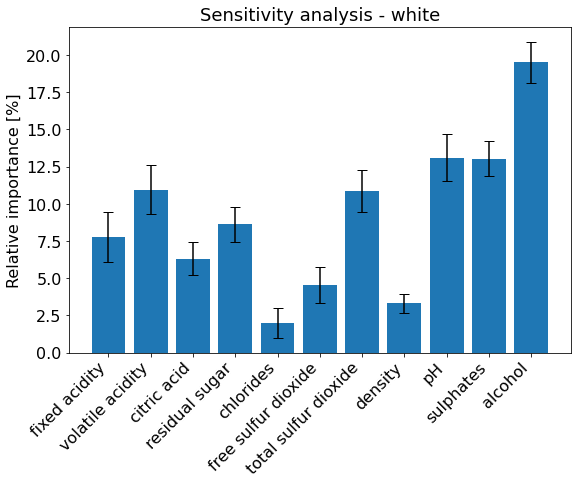

In [25]:
features = ["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"]
plt.figure(figsize=(9, 6))
plt.bar(features, imp_avg, yerr=imp_std, capsize=5)
plt.ylabel('Relative importance [%]', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=16)
plt.title('Sensitivity analysis - white', fontsize=18)
plt.show()

### Significance anlysis

In [10]:
def get_permutation_scores(X, y, model, n_permutations=100):
    scores = np.zeros(n_permutations)
    predictions = model.predict(X)
    real_score = accuracy_score(y, predictions)
    pvalue = 0
    for i in range(n_permutations):
        y_permuted = np.random.permutation(y)
        scores[i] = accuracy_score(y_permuted, predictions)
        if scores[i] > real_score:
            pvalue += 1
    pvalue /= n_permutations
    return (scores, real_score, pvalue)

i_mod = 3
perm_scores, score, pvalue = get_permutation_scores(X[i_mod*divsize:(i_mod+1)*divsize, :], y[i_mod*divsize:(i_mod+1)*divsize], models[i_mod], 10000)
print(pvalue)

0.0


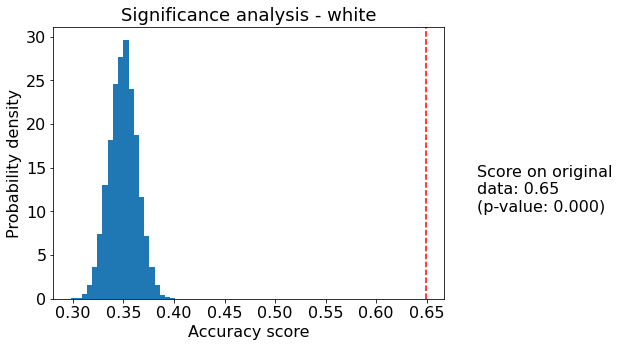

In [23]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.hist(perm_scores, bins=20, density=True)
ax.axvline(score, ls="--", color="r")
score_label = f"Score on original\ndata: {score:.2f}\n(p-value: {pvalue:.3f})"
ax.text(0.7, 10, score_label, fontsize=16)
ax.set_title("Significance analysis - white", fontsize=18)
ax.tick_params(axis='both', labelsize=16)
ax.set_xlabel("Accuracy score", fontsize=16)
_ = ax.set_ylabel("Probability density", fontsize=16)